In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# from src.model_diagnostics import create_heatmap


In [10]:


def calculate_recall_scores(data, target_column:str, prediction_column:str, labels:list[str], null_value:int=-1,):
    """Calculates recall scores for each class, and globally for the heatmap visual."""
    # Store values in this list
    # ---------
    recall_scores = []

    # Calculate the precision for each label
    for label in labels:
        precision = recall_score(data[target_column], data[prediction_column], labels=[label], average='macro')
        recall_scores.append(precision)
    
    # Insert null value
    recall_scores.append(null_value)

    # Insert global precision
    global_precision = recall_score(data[target_column], data[prediction_column], average='weighted')
    recall_scores.append(global_precision)

    # Insert null value
    # recall_scores.append(null_value)

    return recall_scores

def calculate_precision_scores(data, target_column:str, prediction_column:str, labels:list[str], null_value:int=-1):
    """Calculates precision scores for each class, and globally for the heatmap visual."""
    # Store values in this list
    # ---------
    precision_scores = []

    # Calculate the precision for each label
    for label in labels:
        precision = precision_score(data[target_column], data[prediction_column], labels=[label], average='macro')
        precision_scores.append(precision)
    
    # Insert null value
    precision_scores.append(null_value)

    # Insert global precision
    global_precision = precision_score(data[target_column], data[prediction_column], average='weighted')
    precision_scores.append(global_precision)

    # Insert null value
    precision_scores.append(null_value)

    return precision_scores



def cleanup_data_for_heatmap(data, target_column:str, prediction_column:str, null_value=-1):
    """
    Prepares data for a heatmap visualization.  Calculates additional metrics beyond traditional confusion matrix.
    Adds row and column totals.
    Adds precision and recall metrics per class.

    Inputs:
    - data: DataFrame containing the target and prediction columns.
    - target_column: Name of the column with true labels.
    - prediction_column: Name of the column with predicted labels.

    Outputs:
    - matrix_with_totals: a matrix with all values ready for the heatmap.
    - labels: a list of labels for the heatmap.
    """
    from sklearn.metrics import confusion_matrix

    data.sort_values(by=target_column, inplace=True)

    # Get list of labels for the heatmap
    # ---------
    labels = data[target_column].unique()

    # Calculate the base confusion matrix
    # ---------
    confusion_matrix_array = confusion_matrix(data[target_column], data[prediction_column])

    ## ROW OPERATIONS (X Axis, )
    # ---------
    # Calculate row totals
    row_totals = np.sum(confusion_matrix_array, axis=1)
    # Add a blank column
    matrix_with_row_totals = np.column_stack((confusion_matrix_array, [null_value] * len(row_totals)))
    # Add row totals as a new column to the original matrix
    matrix_with_row_totals = np.column_stack((matrix_with_row_totals, row_totals))

    ## COLUMN OPERATIONS (Y Axis, )
    # ---------
    # Calculate column totals
    column_totals = np.sum(confusion_matrix_array, axis=0)
    # Create a blank row
    blank_row = [null_value] * len(matrix_with_row_totals[0])
    # Create a row of totals
    totals_row = np.append(column_totals, (np.sum(column_totals).astype(float)))
    # Add a blank value at the second to last position of the row
    totals_row = np.insert(totals_row, -1, null_value, axis=0)
    # Put the totals and blank row together
    rows_to_add = np.row_stack((blank_row, totals_row))
    # Add new rows to the matrix
    matrix_with_rows = np.row_stack((matrix_with_row_totals, rows_to_add))

    ## CALCULATE METRICS
    # ---------
    ## Add recall to matrix
    recall_scores = calculate_recall_scores(data, target_column, prediction_column, labels)
    matrix_with_recall = np.column_stack((matrix_with_rows, recall_scores))
    ## Add precision to matrix
    precision_scores = calculate_precision_scores(data, target_column, prediction_column, labels)
    matrix_with_precision = np.row_stack((matrix_with_recall, precision_scores))
    ## Add additional tick labels to labels
    # labels = np.append(labels, np.array(["", "Count", "Metric"]))


    return matrix_with_precision, labels


def create_heatmap(matrix, labels:list[str], null_value:int=-1):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('white')

    matrix = np.round(matrix, 2)
    
    # Set up the heatmap
    # ---------
    heatmap = plt.pcolor(matrix, 
                        linewidth=2.5, 
                        edgecolor="white", 
                        cmap='Purples', 
                        alpha=0.9)

    # Annotate the heatmap with scores
    # ---------
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            # Skip printing of label when assigned "null_value" value
            if matrix[y,x] == null_value:
                continue
            else:
                # Print everything else as integer
                plt.text(x + 0.5, y + 0.5, matrix[y, x].astype(float),
                        horizontalalignment='center',
                        verticalalignment='center'
                        )
        
            
    # Add labels to axes
    # ---------
    # np.arange part is to center the labels.
    ax.set_xlabel("         Model Prediction", fontsize=18, loc="left", labelpad=10)
    ax.set_xticks(np.arange(3)+0.5, labels, fontsize=14)
    ax.set_ylabel("         Ground Truth", fontsize=18, loc="bottom", labelpad=10)
    ax.set_yticks(np.arange(3)+0.5, labels, fontsize=14)

    # Set the title of the heatmap
    # ---------
    ax.set_title("Confusion Matrix", fontsize=20, fontweight="bold")

    plt.text(y=-1, x=-0.1, s="Counts by class are found in the bottom left corner. \nRow and Column totals are calculated in the first layer.\nPrecision is across the top, Recall is down the right, by class then globally.", fontsize=12, ha="left", va="top", color="indigo", fontweight="bold", alpha=1)
    plt.show()

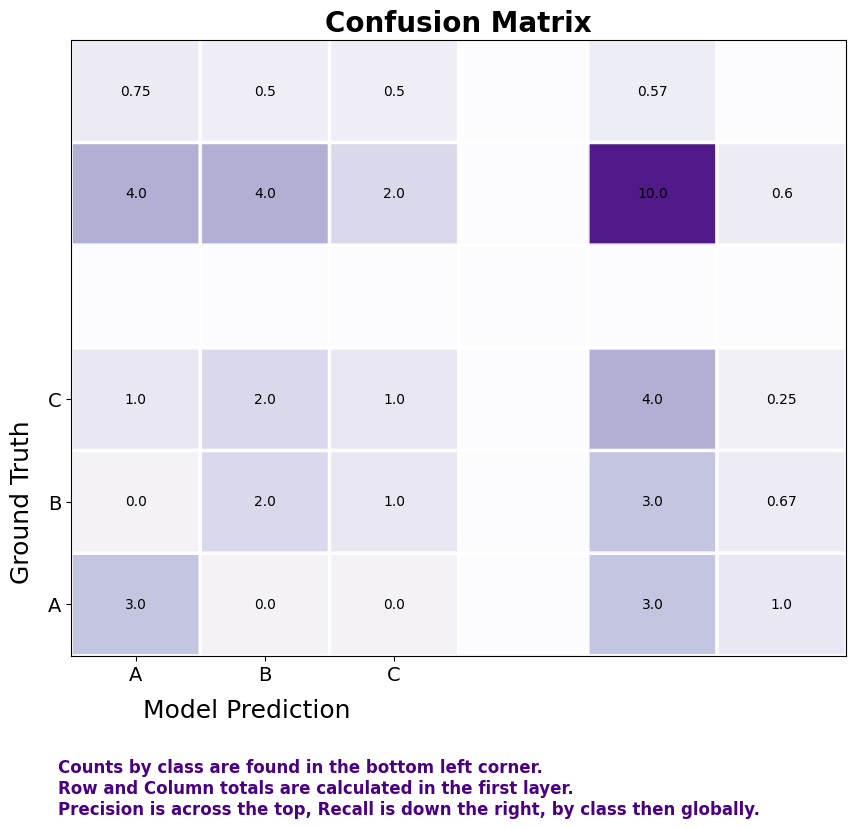

In [11]:
import pandas as pd

df = pd.DataFrame()
df['Target'] = ["C", "A", "C", "C", "A", "B", "B", "A", "C", "B"]
df['Prediction'] = ["A", "A", "C", "B", "A", "C", "B", "A", "B", "B"]

# Prepare data for heatmap
matrix_with_totals, labels = cleanup_data_for_heatmap(df, 'Target', 'Prediction')
# Plot the confusion matrix
create_heatmap(matrix_with_totals, labels=labels)